In [1]:
# Force keras to use the CPU becuase it's actually faster for this size network
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBE_DEVICES"] = ""

import numpy as np
from numpy import cos, sin, pi

from numba import jit

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.constraints import max_norm

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import HTML

import time

from scipy import integrate

import pendubot_module as bot

/Users/sgillen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
first time through was:  -0.05528092384338379
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2


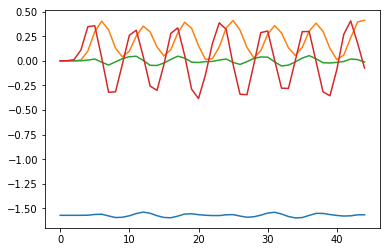

In [3]:
#@jit(nopython=False)
def control(t,q):
    print("2")
    return 1

bot.control = control

# time step
t = np.array([0.0, 20])

rad = np.pi / 180

#y = np.zeros((num_t, num_states, num_trials))

th1 = -pi/2
th2 = 0.0
dth1 = 0.0
dth2 = 0.0

# initial state
state = np.array([th1, th2, dth1, dth2])

# integrate the ODE using scipy.integrate.

start = time.time()
sol = integrate.solve_ivp(bot.derivs, t, state)
end = time.time()
#plt.plot(sol.y.T)
print("first time through was: ", start - end)


start = time.time()
sol = integrate.solve_ivp(bot.derivs, t, state)
end = time.time()
plt.plot(sol.y.T)

print("second time through was: ", start - end)

#ani = animate_pend(sol.y.T)
#HTML(ani.to_jshtml())

In [ ]:
num_trials = 1
num_states = 4
num_t = len(t)
y = np.zeros((num_t, num_states, num_trials))


for i in range(num_trials):
    # initial conditions
    th1 = pi/2
    th2 = 0.0
    dth1 = 0.1#2*(i/num_trials) - 1  # an initial velocity, triggers the swing up control
    dth2 = 0.0

    # initial state
    state = np.array([th1, th2, dth1, dth2])

    # integrate the ODE using scipy.integrate.
    u_hist = []
    y[:, :, i] = integrate.odeint(derivs, state, t)


u = np.zeros((num_t, num_trials))
for i in range(num_trials):
    for t in range(num_t):
        u[t,i] = control(y[t,:,i]) 

        
ani = animate_pend(y[:,:,0])
HTML(ani.to_jshtml())

In [ ]:
# Create our LSTM network

look_back = 1

with tf.variable_scope('pi/pol/'):
    model = Sequential()
    model.add(LSTM(12, input_shape=(4,look_back)))
    #model.add(LSTM(4, input_shape =(12,look_back)))
    model.add(Dense(1))

    #model.add(Dense(2))
    

model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
history = model.fit(y, u, epochs=500, verbose=0)
%matplotlib inline
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [ ]:
# This is a closure that returns our NN controller
def make_controller(model):
    def nn_controller(q):
        if (q[0] < 140 * rad) or (q[0] > 220 * rad):
            return model.predict(q.reshape((1,4,1)))
        else:
            # balancing
            # LQR: K values from MATLAB
            k1 = 140.560
            k2 = -3.162
            k3 = 41.772
            k4 = -8.314
            u = -(k1 * (q[0] - pi) + k2 * q[1] + k3 * q[2] + k4 * q[3])
            return u
        
    return nn_controller

In [ ]:
control = make_controller(model)

# initial conditions
theta = 0
x = 0
th_dot = .01 # an initial velocity, triggers the swing up control
xdot = 0.0
t = np.arange(0.0, 20, dt)


# initial state
state = np.array([theta, x, th_dot, xdot])

# integrate the ODE using scipy.integrate.
y_test = integrate.odeint(derivs, state, t)

#ani = animate_pend(y_test)
#HTML(ani.to_html5_video())

In [ ]:
def run_swingup():
    control = make_controller(model)
    
    # initial conditions
    theta = 0
    x = 0
    th_dot = .01 # an initial velocity, triggers the swing up control
    xdot = 0.0
    t = np.arange(0.0, 20, dt)


    # initial state
    state = np.array([theta, x, th_dot, xdot])

    # integrate the ODE using scipy.integrate.
    y_test = integrate.odeint(derivs, state, t)

    #ani = animate_pend(y_test)
    #HTML(ani.to_html5_video())

In [ ]:
control = make_controller(model)

# initial conditions
theta = 0
x = 0
th_dot = .01 # an initial velocity, triggers the swing up control
xdot = 0.0
t_index = np.arange(0.0, 2, dt)


# initial state
state = np.array([theta, x, th_dot, xdot])

# integrate the ODE using scipy.integrate.
# Fill in our u after the fact..
y_test = integrate.odeint(derivs, state, t_index)
u_test = np.zeros((y.shape[0],1))
for t in range(num_t):
        u_test[t] = control(y[t]) 

        
data = np.concatenate((y_test, u_test),axis=1)
names = ['theta','x','thetadot','xdot','u']
yf = pd.DataFrame(data = data, index = t_index, columns = names)


ani = animate_pend(y_test)
HTML(ani.to_html5_video())

In [ ]:
plt.plot(yf['state','theta'])
old_theta = yf['state','theta']


In [ ]:
new_theta = yf['theta']

In [ ]:
np.all(old_theta == new_theta)

In [ ]:
N_train = 1000
from numpy.random import choice
one_indexes = choice(a=N_train, size=int(N_train / 2), replace=False)
X_train[one_indexes, 0] = 1  # very long term memory.

In [ ]:
# messing with multiindexing 
# TODO probably move this to the misc folder, preferably as a more complete example than this one.

names = [
    ('state', 'theta'),
    ('state', 'x'),
    ('state', 'thetadot'),
    ('state', 'xdot'),
    ('control' ,'u')
]

yf = pd.DataFrame(data = data, index = t_index, columns=pd.MultiIndex.from_tuples(names))